In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

import networkx as nx

In [2]:
routenames = ['Airline', 'Airline_ID', 'Src_IATA', 'Src_ID', 
            'Des_IATA', 'Des_ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv("routes.dat",header = None,names = routenames,encoding = 'utf-8', na_values='\\N')
routes.dropna(subset=["Airline_ID"], inplace=True)

airlines = pd.read_csv("airlines.dat",names = ['Airline_ID','Name','Alias','IATA','ICAO','Callsign','Country','Active'])

airports = pd.read_csv("airports.dat",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'], na_values='\\N')

In [3]:
routes.head(5)

,Airline,Airline_ID,Src_IATA,Src_ID,Des_IATA,Des_ID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,NaN,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,NaN,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,NaN,0,CR2


In [4]:
airports.head(5)

,Airport_ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ database,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


In [5]:
route_active = pd.merge(routes,airlines[['Airline_ID','Active']].copy().drop_duplicates('Airline_ID'))
route_active = route_active.loc[(route_active.Active=='Y')].copy()
route_active.drop(columns=['Airline','Airline_ID','Codeshare','Active'],inplace=True)
route_active.dropna(subset=['Equipment'],inplace=True)
route_active.reset_index(level=0, drop=True,inplace=True)
route_active.head()

,Src_IATA,Src_ID,Des_IATA,Des_ID,Stops,Equipment
0,AER,2965.0,KZN,2990.0,0,CR2
1,ASF,2966.0,KZN,2990.0,0,CR2
2,ASF,2966.0,MRV,2962.0,0,CR2
3,CEK,2968.0,KZN,2990.0,0,CR2
4,CEK,2968.0,OVB,4078.0,0,CR2


In [6]:
capacity = pd.read_excel('capacity.xlsx',header=None,index_col=0)
capacity.columns = ['Equipment','Capacity','test']
capacity = capacity[['Equipment','Capacity']]

In [7]:
capacity.dropna(subset=['Capacity'],inplace=True)
capacity.Equipment = capacity.Equipment.astype('str')
capacity.set_index('Equipment',inplace=True)

In [8]:
cap_list = []
for i in range(len(route_active)):
    tmp = route_active.iloc[i].Equipment#.get_values()
    cap = []
    for equip in tmp.split():
        try:
            cap_tmp = capacity.loc[equip].Capacity
            cap.append(cap_tmp)
        except:
            continue
    cap_list.append(np.mean(cap))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
route_active['Capacity'] = cap_list
route_active.dropna(subset=['Capacity'],inplace=True)

In [10]:
src_cap = route_active[['Src_ID','Capacity']].groupby('Src_ID').sum()
des_cap = route_active[['Des_ID','Capacity']].groupby('Des_ID').sum()

In [11]:
src_des_cap = pd.concat([src_cap,des_cap], axis=1, sort=True).fillna(0)
src_des_cap.columns = ['Src_cap','Des_cap']
src_des_cap.reset_index(level=0, inplace=True)
src_des_cap.rename(columns={'index':'Airport_ID'},inplace=True)
src_des_cap.head(2)

,Airport_ID,Src_cap,Des_cap
0,1.0,241.666667,241.666667
1,2.0,540.000000,540.000000


In [12]:
portgeo = pd.DataFrame(pd.concat([routes.Src_ID,routes.Des_ID],axis=0).drop_duplicates())
portgeo.rename(columns={0:'Airport_ID'},inplace=True)
portgeo.reset_index(level=0, drop=True,inplace=True)
portgeo = portgeo.merge(src_des_cap,on='Airport_ID')
portgeo.head(5)

,Airport_ID,Src_cap,Des_cap
0,2965.0,3429.333333,3429.333333
1,2966.0,820.000000,820.000000
2,2968.0,2514.000000,2514.000000
3,4029.0,52573.716667,52708.383333
4,6156.0,693.000000,693.000000


In [13]:
portgeo = portgeo.merge(airports[['Name','City','Country','IATA','Latitude','Longitude','Airport_ID']],on='Airport_ID')
portgeo.reset_index(level=0, inplace=True)
portgeo.rename(columns={'index':'node_idx'},inplace=True)
portgeo.head(5)

,node_idx,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
0,0,2965.0,3429.333333,3429.333333,Sochi International Airport,Sochi,Russia,AER,43.449902,39.956600
1,1,2966.0,820.000000,820.000000,Astrakhan Airport,Astrakhan,Russia,ASF,46.283298,48.006302
2,2,2968.0,2514.000000,2514.000000,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,55.305801,61.503300
3,3,4029.0,52573.716667,52708.383333,Domodedovo International Airport,Moscow,Russia,DME,55.408798,37.906300
4,4,6156.0,693.000000,693.000000,Belgorod International Airport,Belgorod,Russia,EGO,50.643799,36.590099


In [14]:
route_active.loc[117]

Src_IATA     ARN
Src_ID       737
Des_IATA     POR
Des_ID       448
Stops          0
Equipment    SF3
Capacity      37
Name: 117, dtype: object

In [15]:
#portgeo.to_csv('portgeo.csv',index=False)
portgeo = pd.read_csv('portgeo.csv')

In [16]:
portgeo.sort_values(by='Src_cap',ascending=False).head(10)

,node_idx,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
426,426,507.0,143397.716667,142622.800000,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941
162,162,3682.0,141866.095238,139436.509524,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101
269,269,3364.0,115172.759524,114819.426190,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999
400,400,1382.0,113029.350000,111103.600000,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000
412,412,340.0,106306.785714,105942.619048,Frankfurt am Main Airport,Frankfurt,Germany,FRA,50.033333,8.570556
329,329,3797.0,99766.800000,100187.400000,John F Kennedy International Airport,New York,United States,JFK,40.639801,-73.778900
301,301,3484.0,95866.950000,96717.783333,Los Angeles International Airport,Los Angeles,United States,LAX,33.942501,-118.407997
245,245,3930.0,94953.850000,95024.850000,Incheon International Airport,Seoul,South Korea,ICN,37.469101,126.450996
145,145,3316.0,94079.000000,95077.833333,Singapore Changi Airport,Singapore,Singapore,SIN,1.350190,103.994003
131,131,3885.0,88661.621429,88772.954762,Suvarnabhumi Airport,Bangkok,Thailand,BKK,13.681100,100.747002


In [18]:
adj = np.zeros((len(portgeo),len(portgeo)))
adj_cap = np.zeros((len(portgeo),len(portgeo)))
cnt = 0
for i in range(len(route_active)):
    src_ID = route_active.iloc[i].Src_ID
    des_ID = route_active.iloc[i].Des_ID
    src_IATA = route_active.iloc[i].Src_IATA
    des_IATA = route_active.iloc[i].Des_IATA
    cap = route_active.iloc[i].Capacity
    if (src_ID in portgeo.Airport_ID.get_values()) & (des_ID in portgeo.Airport_ID.get_values()):
        src_idx = portgeo.loc[portgeo.Airport_ID==src_ID].node_idx.get_values()[0]
        des_idx = portgeo.loc[portgeo.Airport_ID==des_ID].node_idx.get_values()[0]
        adj[src_idx][des_idx] += 1
        if cap:
            adj_cap[src_idx][des_idx] += cap
    else: 
        cnt +=1
        print(cnt,src_IATA,des_IATA)

1 DME TGK
2 TGK DME
3 ADQ AOS
4 ADQ KKB
5 ADQ KOZ
6 ADQ OLH
7 AOS KZB
8 KKB SYB
9 KOZ ORI
10 SYB KPR
11 CGA HYL
12 CGA KTN
13 HYL CGA
14 HYL KTB
15 HYL KTN
16 KTB HYL
17 KTB KTN
18 KTN CGA
19 KTN HYL
20 KTN KTB
21 CKG PZI
22 CTU JIQ
23 CTU PZI
24 JIQ CTU
25 NTG WUH
26 PZI CKG
27 PZI CTU
28 TVS TYN
29 TYN TVS
30 WUH NTG
31 MEX PQM
32 PQM MEX
33 CPT PBZ
34 ELL JNB
35 JNB ELL
36 PBZ CPT
37 PBZ JNB
38 AMD HYD
39 BBI HYD
40 BLR HYD
41 BOM HYD
42 CCU HYD
43 COK HYD
44 DEL HYD
45 DXB HYD
46 GOI HYD
47 HYD AMD
48 HYD BBI
49 HYD BLR
50 HYD BOM
51 HYD CCU
52 HYD COK
53 HYD DEL
54 HYD DXB
55 HYD GOI
56 HYD JAI
57 HYD MAA
58 HYD PNQ
59 HYD RPR
60 HYD VTZ
61 JAI HYD
62 MAA HYD
63 PNQ HYD
64 RPR HYD
65 VTZ HYD
66 PHO PIZ
67 PIZ PHO
68 ACU PAC
69 BFQ JQE
70 GHE PAC
71 MPP PAC
72 OGM MPP
73 OTD SIC
74 PAC BFQ
75 PAC OGM
76 PAC OTD
77 PAC PVE
78 PAC PYC
79 PAC SAX
80 PVE CZJ
81 PYC ACU
82 SAX GHE
83 OME WBB
84 WBB SMK
85 YKT ZEL
86 ZEL YKT
87 BEN MRA
88 IST MRA
89 MRA BEN
90 MRA IST
91 MRA SFA
92 MRA T

693 BNE ZBL
694 ZBL BNE
695 ADD DOH
696 AMD DOH
697 AMM DOH
698 ARN DOH
699 ATH DOH
700 ATQ DOH
701 AUH DOH
702 BAH DOH
703 BCN DOH
704 BEY DOH
705 BGW DOH
706 BLR DOH
707 BRU DOH
708 BSR DOH
709 BUD DOH
710 CAI DOH
711 CCJ DOH
712 CCU DOH
713 CDG DOH
714 CGK DOH
715 CKG DOH
716 CMB DOH
717 CMN DOH
718 COK DOH
719 CPH DOH
720 CPT DOH
721 CRK DOH
722 CTU DOH
723 DAC DOH
724 DAR DOH
725 DEL DOH
726 DME DOH
727 DMM DOH
728 DOH ADD
729 DOH AMD
730 DOH AMM
731 DOH ARN
732 DOH ATH
733 DOH ATQ
734 DOH AUH
735 DOH BAH
736 DOH BCN
737 DOH BEY
738 DOH BGW
739 DOH BLR
740 DOH BRU
741 DOH BSR
742 DOH BUD
743 DOH CAI
744 DOH CCJ
745 DOH CCU
746 DOH CDG
747 DOH CGK
748 DOH CKG
749 DOH CMB
750 DOH CMN
751 DOH COK
752 DOH CPH
753 DOH CRK
754 DOH CTU
755 DOH DAC
756 DOH DAR
757 DOH DEL
758 DOH DME
759 DOH DMM
760 DOH DWC
761 DOH DXB
762 DOH EBB
763 DOH EBL
764 DOH ELQ
765 DOH ESB
766 DOH FCO
767 DOH FRA
768 DOH GOI
769 DOH GRU
770 DOH GVA
771 DOH GYD
772 DOH HBE
773 DOH HGH
774 DOH HKG
775 DOH HYD
776 

In [19]:
route_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65114 entries, 0 to 66494
Data columns (total 7 columns):
Src_IATA     65114 non-null object
Src_ID       64952 non-null float64
Des_IATA     65114 non-null object
Des_ID       64954 non-null float64
Stops        65114 non-null int64
Equipment    65114 non-null object
Capacity     65114 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 6.5+ MB


In [20]:
cnt/i

0.01895166863759925

2.2% flights cannot find the longitude or latitude of their source or destination airport.

In [45]:
np.save('weighted_adj', adj)
np.save('weighted_cap_adj', adj_cap)

## Load the graph

In [17]:
adj = np.load('weighted_adj.npy')
adj_cap = np.load('weighted_cap_adj.npy')

In [22]:
G=nx.from_numpy_array(adj_cap)

In [23]:
GC = max(nx.connected_component_subgraphs(G), key=len)

In [35]:
n_nodes = len(G)
n_degree = np.sum(adj_cap,axis=1)
idx_hub = np.where(n_degree>50000)

In [39]:
portgeo.loc[idx_hub].sort_values(by='Src_cap',ascending=False)

,node_idx,Airport_ID,Src_cap,Des_cap,Name,City,Country,IATA,Latitude,Longitude
426,426,507.0,143397.716667,142622.800000,London Heathrow Airport,London,United Kingdom,LHR,51.470600,-0.461941
162,162,3682.0,141866.095238,139436.509524,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,33.636700,-84.428101
269,269,3364.0,115172.759524,114819.426190,Beijing Capital International Airport,Beijing,China,PEK,40.080101,116.584999
400,400,1382.0,113029.350000,111103.600000,Charles de Gaulle International Airport,Paris,France,CDG,49.012798,2.550000
412,412,340.0,106306.785714,105942.619048,Frankfurt am Main Airport,Frankfurt,Germany,FRA,50.033333,8.570556
329,329,3797.0,99766.800000,100187.400000,John F Kennedy International Airport,New York,United States,JFK,40.639801,-73.778900
301,301,3484.0,95866.950000,96717.783333,Los Angeles International Airport,Los Angeles,United States,LAX,33.942501,-118.407997
245,245,3930.0,94953.850000,95024.850000,Incheon International Airport,Seoul,South Korea,ICN,37.469101,126.450996
145,145,3316.0,94079.000000,95077.833333,Singapore Changi Airport,Singapore,Singapore,SIN,1.350190,103.994003
131,131,3885.0,88661.621429,88772.954762,Suvarnabhumi Airport,Bangkok,Thailand,BKK,13.681100,100.747002


In [42]:
def G_pos(x,y,n_nodes): # function to return the position(latitiude and longtitude) of  each node (for plot)
    pos_dic = {}
    for i in range(n_nodes):
        pos_dic[i] = x[i],y[i]
    return pos_dic

In [43]:
longitude = portgeo.Longitude.get_values()
latitude = portgeo.Latitude.get_values()

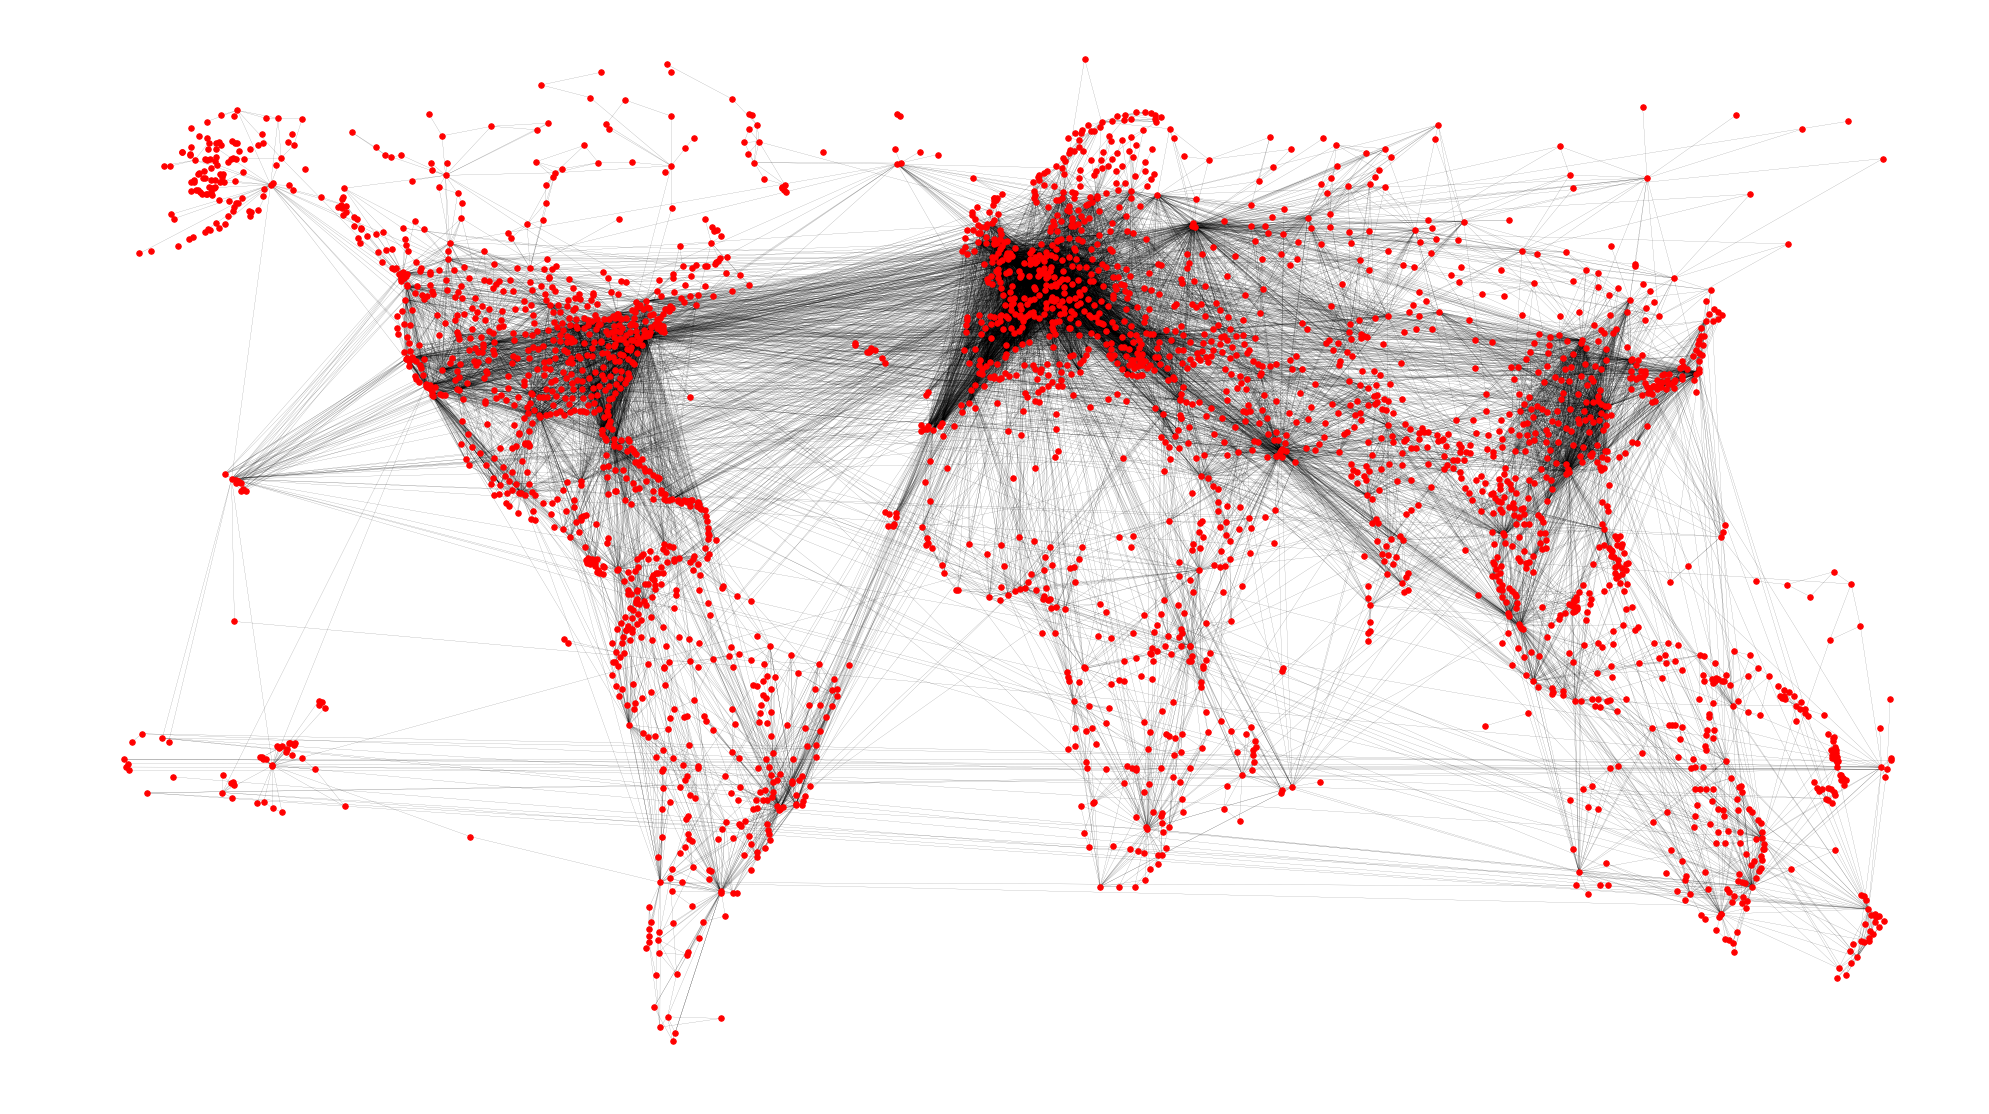

In [44]:
pos = G_pos(x=longitude,y=latitude,n_nodes=n_nodes) # return the positions (latitiude and longtitude) of all nodes
plt.figure(figsize=(15*1.8,15))

nx.draw(G, pos=pos,node_size=30,width=0.1,cmap='RdYlBu')